## UNet starter for Steel defect detection challenge


This kernel uses a UNet model with pretrained resnet18 encoder for this challenge, with simple augmentations using albumentations library, uses BCE loss, metrics like Dice and IoU. I've used [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) which comes with a lot pre-implemented segmentation architectures. This is a modified version of my previous [kernel](https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch) for [siim-acr-pneumothorax-segmentation](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/) competition.

**As internet is not allowed for this competition, I tried installing `segmentation_models.pytorch` by source using pip but due to some reasons it didn't work. So, as a [Jugaad](https://en.wikipedia.org/wiki/Jugaad) I took all of `segmentation_models.pytorch`'s UNet code and wrote it in a single file and added it as a dataset so as to use it for this kernel, its dependency [pretrained-models.pytorch](https://github.com/Cadene/pretrained-models.pytorch) is also added as a dataset.

Updates:
* V16: Bugfix in overall `dice_neg` and `dice_pos` computation

In [1]:
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null # no output
package_path = '../input/unetmodelscript' # add unet script dataset
import sys
sys.path.append(package_path)
from model import Unet # import Unet model from the script

ERROR: Invalid requirement: '../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/'
Hint: It looks like a path. File '../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/' does not exist.


ModuleNotFoundError: No module named 'model'

## Torchvision_models

In [6]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division, absolute_import
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import types
import re

#################################################################
# You can find the definitions of those models here:
# https://github.com/pytorch/vision/blob/master/torchvision/models
#
# To fit the API, we usually added/redefined some methods and
# renamed some attributs (see below for each models).
#
# However, you usually do not need to see the original model
# definition from torchvision. Just use `print(model)` to see
# the modules and see bellow the `model.features` and
# `model.classifier` definitions.
#################################################################

__all__ = [
    'alexnet',
    'densenet121', 'densenet169', 'densenet201', 'densenet161',
    'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'inceptionv3',
    'squeezenet1_0', 'squeezenet1_1',
    'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19'
]

model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    'densenet121': 'http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth',
    'densenet169': 'http://data.lip6.fr/cadene/pretrainedmodels/densenet169-f470b90a4.pth',
    'densenet201': 'http://data.lip6.fr/cadene/pretrainedmodels/densenet201-5750cbb1e.pth',
    'densenet161': 'http://data.lip6.fr/cadene/pretrainedmodels/densenet161-347e6b360.pth',
    'inceptionv3': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
    # 'vgg16_caffe': 'https://s3-us-west-2.amazonaws.com/jcjohns-models/vgg16-00b39a1b.pth',
    # 'vgg19_caffe': 'https://s3-us-west-2.amazonaws.com/jcjohns-models/vgg19-d01eb7cb.pth'
}

input_sizes = {}
means = {}
stds = {}

for model_name in __all__:
    input_sizes[model_name] = [3, 224, 224]
    means[model_name] = [0.485, 0.456, 0.406]
    stds[model_name] = [0.229, 0.224, 0.225]

for model_name in ['inceptionv3']:
    input_sizes[model_name] = [3, 299, 299]
    means[model_name] = [0.5, 0.5, 0.5]
    stds[model_name] = [0.5, 0.5, 0.5]

pretrained_settings = {}

for model_name in __all__:
    pretrained_settings[model_name] = {
        'imagenet': {
            'url': model_urls[model_name],
            'input_space': 'RGB',
            'input_size': input_sizes[model_name],
            'input_range': [0, 1],
            'mean': means[model_name],
            'std': stds[model_name],
            'num_classes': 1000
        }
    }

# for model_name in ['vgg16', 'vgg19']:
#     pretrained_settings[model_name]['imagenet_caffe'] = {
#         'url': model_urls[model_name + '_caffe'],
#         'input_space': 'BGR',
#         'input_size': input_sizes[model_name],
#         'input_range': [0, 255],
#         'mean': [103.939, 116.779, 123.68],
#         'std': [1., 1., 1.],
#         'num_classes': 1000
#     }

def update_state_dict(state_dict):
    # '.'s are no longer allowed in module names, but pervious _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    return state_dict

def load_pretrained(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)
    state_dict = model_zoo.load_url(settings['url'])
    state_dict = update_state_dict(state_dict)
    model.load_state_dict(state_dict)
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']
    return model

#################################################################
# AlexNet

def modify_alexnet(model):
    # Modify attributs
    model._features = model.features
    del model.features
    model.dropout0 = model.classifier[0]
    model.linear0 = model.classifier[1]
    model.relu0 = model.classifier[2]
    model.dropout1 = model.classifier[3]
    model.linear1 = model.classifier[4]
    model.relu1 = model.classifier[5]
    model.last_linear = model.classifier[6]
    del model.classifier

    def features(self, input):
        x = self._features(input)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.dropout0(x)
        x = self.linear0(x)
        x = self.relu0(x)
        x = self.dropout1(x)
        x = self.linear1(x)
        return x

    def logits(self, features):
        x = self.relu1(features)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

    # Modify methods
    model.features = types.MethodType(features, model)
    model.logits = types.MethodType(logits, model)
    model.forward = types.MethodType(forward, model)
    return model

def alexnet(num_classes=1000, pretrained='imagenet'):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    # https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
    model = models.alexnet(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['alexnet'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_alexnet(model)
    return model

###############################################################
# DenseNets

def modify_densenets(model):
    # Modify attributs
    model.last_linear = model.classifier
    del model.classifier

    def logits(self, features):
        x = F.relu(features, inplace=True)
        x = F.avg_pool2d(x, kernel_size=7, stride=1)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

    # Modify methods
    model.logits = types.MethodType(logits, model)
    model.forward = types.MethodType(forward, model)
    return model

def densenet121(num_classes=1000, pretrained='imagenet'):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    """
    model = models.densenet121(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['densenet121'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_densenets(model)
    return model

def densenet169(num_classes=1000, pretrained='imagenet'):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    """
    model = models.densenet169(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['densenet169'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_densenets(model)
    return model

def densenet201(num_classes=1000, pretrained='imagenet'):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    """
    model = models.densenet201(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['densenet201'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_densenets(model)
    return model

def densenet161(num_classes=1000, pretrained='imagenet'):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    """
    model = models.densenet161(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['densenet161'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_densenets(model)
    return model

###############################################################
# InceptionV3

def inceptionv3(num_classes=1000, pretrained='imagenet'):
    r"""Inception v3 model architecture from
    `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
    """
    model = models.inception_v3(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['inceptionv3'][pretrained]
        model = load_pretrained(model, num_classes, settings)

    # Modify attributs
    model.last_linear = model.fc
    del model.fc

    def features(self, input):
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(input) # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x) # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x) # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2) # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x) # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x) # 71 x 71 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2) # 35 x 35 x 192
        x = self.Mixed_5b(x) # 35 x 35 x 256
        x = self.Mixed_5c(x) # 35 x 35 x 288
        x = self.Mixed_5d(x) # 35 x 35 x 288
        x = self.Mixed_6a(x) # 17 x 17 x 768
        x = self.Mixed_6b(x) # 17 x 17 x 768
        x = self.Mixed_6c(x) # 17 x 17 x 768
        x = self.Mixed_6d(x) # 17 x 17 x 768
        x = self.Mixed_6e(x) # 17 x 17 x 768
        if self.training and self.aux_logits:
            self._out_aux = self.AuxLogits(x) # 17 x 17 x 768
        x = self.Mixed_7a(x) # 8 x 8 x 1280
        x = self.Mixed_7b(x) # 8 x 8 x 2048
        x = self.Mixed_7c(x) # 8 x 8 x 2048
        return x

    def logits(self, features):
        x = F.avg_pool2d(features, kernel_size=8) # 1 x 1 x 2048
        x = F.dropout(x, training=self.training) # 1 x 1 x 2048
        x = x.view(x.size(0), -1) # 2048
        x = self.last_linear(x) # 1000 (num_classes)
        if self.training and self.aux_logits:
            aux = self._out_aux
            self._out_aux = None
            return x, aux
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

    # Modify methods
    model.features = types.MethodType(features, model)
    model.logits = types.MethodType(logits, model)
    model.forward = types.MethodType(forward, model)
    return model

###############################################################
# ResNets

def modify_resnets(model):
    # Modify attributs
    model.last_linear = model.fc
    model.fc = None

    def features(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, features):
        x = self.avgpool(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

    # Modify methods
    model.features = types.MethodType(features, model)
    model.logits = types.MethodType(logits, model)
    model.forward = types.MethodType(forward, model)
    return model

def resnet18(num_classes=1000, pretrained='imagenet'):
    """Constructs a ResNet-18 model.
    """
    model = models.resnet18(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['resnet18'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_resnets(model)
    return model

def resnet34(num_classes=1000, pretrained='imagenet'):
    """Constructs a ResNet-34 model.
    """
    model = models.resnet34(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['resnet34'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_resnets(model)
    return model

def resnet50(num_classes=1000, pretrained='imagenet'):
    """Constructs a ResNet-50 model.
    """
    model = models.resnet50(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['resnet50'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_resnets(model)
    return model

def resnet101(num_classes=1000, pretrained='imagenet'):
    """Constructs a ResNet-101 model.
    """
    model = models.resnet101(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['resnet101'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_resnets(model)
    return model

def resnet152(num_classes=1000, pretrained='imagenet'):
    """Constructs a ResNet-152 model.
    """
    model = models.resnet152(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['resnet152'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_resnets(model)
    return model

###############################################################
# SqueezeNets

def modify_squeezenets(model):
    # /!\ Beware squeezenets do not have any last_linear module

    # Modify attributs
    model.dropout = model.classifier[0]
    model.last_conv = model.classifier[1]
    model.relu = model.classifier[2]
    model.avgpool = model.classifier[3]
    del model.classifier

    def logits(self, features):
        x = self.dropout(features)
        x = self.last_conv(x)
        x = self.relu(x)
        x = self.avgpool(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

    # Modify methods
    model.logits = types.MethodType(logits, model)
    model.forward = types.MethodType(forward, model)
    return model

def squeezenet1_0(num_classes=1000, pretrained='imagenet'):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.
    """
    model = models.squeezenet1_0(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['squeezenet1_0'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_squeezenets(model)
    return model

def squeezenet1_1(num_classes=1000, pretrained='imagenet'):
    r"""SqueezeNet 1.1 model from the `official SqueezeNet repo
    <https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1>`_.
    SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters
    than SqueezeNet 1.0, without sacrificing accuracy.
    """
    model = models.squeezenet1_1(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['squeezenet1_1'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_squeezenets(model)
    return model

###############################################################
# VGGs

def modify_vggs(model):
    # Modify attributs
    model._features = model.features
    del model.features
    model.linear0 = model.classifier[0]
    model.relu0 = model.classifier[1]
    model.dropout0 = model.classifier[2]
    model.linear1 = model.classifier[3]
    model.relu1 = model.classifier[4]
    model.dropout1 = model.classifier[5]
    model.last_linear = model.classifier[6]
    del model.classifier

    def features(self, input):
        x = self._features(input)
        x = x.view(x.size(0), -1)
        x = self.linear0(x)
        x = self.relu0(x)
        x = self.dropout0(x)
        x = self.linear1(x)
        return x

    def logits(self, features):
        x = self.relu1(features)
        x = self.dropout1(x)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

    # Modify methods
    model.features = types.MethodType(features, model)
    model.logits = types.MethodType(logits, model)
    model.forward = types.MethodType(forward, model)
    return model

def vgg11(num_classes=1000, pretrained='imagenet'):
    """VGG 11-layer model (configuration "A")
    """
    model = models.vgg11(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['vgg11'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_vggs(model)
    return model

def vgg11_bn(num_classes=1000, pretrained='imagenet'):
    """VGG 11-layer model (configuration "A") with batch normalization
    """
    model = models.vgg11_bn(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['vgg11_bn'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_vggs(model)
    return model

def vgg13(num_classes=1000, pretrained='imagenet'):
    """VGG 13-layer model (configuration "B")
    """
    model = models.vgg13(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['vgg13'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_vggs(model)
    return model

def vgg13_bn(num_classes=1000, pretrained='imagenet'):
    """VGG 13-layer model (configuration "B") with batch normalization
    """
    model = models.vgg13_bn(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['vgg13_bn'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_vggs(model)
    return model

def vgg16(num_classes=1000, pretrained='imagenet'):
    """VGG 16-layer model (configuration "D")
    """
    model = models.vgg16(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['vgg16'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_vggs(model)
    return model

def vgg16_bn(num_classes=1000, pretrained='imagenet'):
    """VGG 16-layer model (configuration "D") with batch normalization
    """
    model = models.vgg16_bn(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['vgg16_bn'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_vggs(model)
    return model

def vgg19(num_classes=1000, pretrained='imagenet'):
    """VGG 19-layer model (configuration "E")
    """
    model = models.vgg19(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['vgg19'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_vggs(model)
    return model

def vgg19_bn(num_classes=1000, pretrained='imagenet'):
    """VGG 19-layer model (configuration 'E') with batch normalization
    """
    model = models.vgg19_bn(pretrained=False)
    if pretrained is not None:
        settings = pretrained_settings['vgg19_bn'][pretrained]
        model = load_pretrained(model, num_classes, settings)
    model = modify_vggs(model)
    return model


## model

In [7]:
import functools
import torch.utils.model_zoo as model_zoo
from torchvision.models.resnet import ResNet
from torchvision.models.resnet import BasicBlock
from torchvision.models.resnet import Bottleneck
#from pretrainedmodels.models.torchvision_models import pretrained_settings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


def preprocess_input(x, mean=None, std=None, input_space='RGB', input_range=None, **kwargs):

    if input_space == 'BGR':
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


class Model(nn.Module):

    def __init__(self):
        super().__init__()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


class Conv2dReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, use_batchnorm=True, **batchnorm_params):

        super().__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=not (use_batchnorm)),
            nn.ReLU(inplace=True),
        ]

        if use_batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels, **batchnorm_params))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class EncoderDecoder(Model):

    def __init__(self, encoder, decoder, activation):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        if callable(activation) or activation is None:
            self.activation = activation
        elif activation == 'softmax':
            self.activation = nn.Softmax(dim=1)
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError('Activation should be "sigmoid"/"softmax"/callable/None')

    def forward(self, x):
        """Sequentially pass `x` trough model`s `encoder` and `decoder` (return logits!)"""
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)`
        and apply activation function (if activation is not `None`) with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        with torch.no_grad():
            x = self.forward(x)
            if self.activation:
                x = self.activation(x)

        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            Conv2dReLU(in_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm),
            Conv2dReLU(out_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm),
        )

    def forward(self, x):
        x, skip = x
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.block(x)
        return x


class CenterBlock(DecoderBlock):

    def forward(self, x):
        return self.block(x)


class UnetDecoder(Model):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            use_batchnorm=True,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = CenterBlock(channels, channels, use_batchnorm=use_batchnorm)
        else:
            self.center = None

        in_channels = self.compute_channels(encoder_channels, decoder_channels)
        out_channels = decoder_channels

        self.layer1 = DecoderBlock(in_channels[0], out_channels[0], use_batchnorm=use_batchnorm)
        self.layer2 = DecoderBlock(in_channels[1], out_channels[1], use_batchnorm=use_batchnorm)
        self.layer3 = DecoderBlock(in_channels[2], out_channels[2], use_batchnorm=use_batchnorm)
        self.layer4 = DecoderBlock(in_channels[3], out_channels[3], use_batchnorm=use_batchnorm)
        self.layer5 = DecoderBlock(in_channels[4], out_channels[4], use_batchnorm=use_batchnorm)
        self.final_conv = nn.Conv2d(out_channels[4], final_channels, kernel_size=(1, 1))

        self.initialize()

    def compute_channels(self, encoder_channels, decoder_channels):
        channels = [
            encoder_channels[0] + encoder_channels[1],
            encoder_channels[2] + decoder_channels[0],
            encoder_channels[3] + decoder_channels[1],
            encoder_channels[4] + decoder_channels[2],
            0 + decoder_channels[3],
        ]
        return channels

    def forward(self, x):
        encoder_head = x[0]
        skips = x[1:]

        if self.center:
            encoder_head = self.center(encoder_head)

        x = self.layer1([encoder_head, skips[0]])
        x = self.layer2([x, skips[1]])
        x = self.layer3([x, skips[2]])
        x = self.layer4([x, skips[3]])
        x = self.layer5([x, None])
        x = self.final_conv(x)

        return x


class ResNetEncoder(ResNet):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pretrained = False
        del self.fc

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)

        x1 = self.maxpool(x0)
        x1 = self.layer1(x1)

        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return [x4, x3, x2, x1, x0]

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop('fc.bias')
        state_dict.pop('fc.weight')
        super().load_state_dict(state_dict, **kwargs)


resnet_encoders = {
    'resnet18': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet18'],
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [2, 2, 2, 2],
        },
    },

    'resnet34': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet34'],
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [3, 4, 6, 3],
        },
    },

    'resnet50': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet50'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 4, 6, 3],
        },
    },

    'resnet101': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet101'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 4, 23, 3],
        },
    },

    'resnet152': {
        'encoder': ResNetEncoder,
        'pretrained_settings': pretrained_settings['resnet152'],
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 8, 36, 3],
        },
    },
}

encoders = {}
encoders.update(resnet_encoders)

def get_encoder(name, encoder_weights=None):
    Encoder = encoders[name]['encoder']
    encoder = Encoder(**encoders[name]['params'])
    encoder.out_shapes = encoders[name]['out_shapes']

    if encoder_weights is not None:
        settings = encoders[name]['pretrained_settings'][encoder_weights]
        encoder.load_state_dict(model_zoo.load_url(settings['url']))

    return encoder


def get_encoder_names():
    return list(encoders.keys())


def get_preprocessing_fn(encoder_name, pretrained='imagenet'):
    settings = encoders[encoder_name]['pretrained_settings']

    if pretrained not in settings.keys():
        raise ValueError('Avaliable pretrained options {}'.format(settings.keys()))

    input_space = settings[pretrained].get('input_space')
    input_range = settings[pretrained].get('input_range')
    mean = settings[pretrained].get('mean')
    std = settings[pretrained].get('std')
    
    return functools.partial(preprocess_input, mean=mean, std=std, input_space=input_space, input_range=input_range)


class Unet(EncoderDecoder):
    """Unet_ is a fully convolution neural network for image semantic segmentation

    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        activation: activation function used in ``.predict(x)`` method for inference.
            One of [``sigmoid``, ``softmax``, callable, None]
        center: if ``True`` add ``Conv2dReLU`` block on encoder head (useful for VGG models)

    Returns:
        ``torch.nn.Module``: **Unet**

    .. _Unet:
        https://arxiv.org/pdf/1505.04597

    """

    def __init__(
            self,
            encoder_name='resnet34',
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            classes=1,
            activation='sigmoid',
            center=False,  # usefull for VGG models
    ):
        encoder = get_encoder(
            encoder_name,
            encoder_weights=encoder_weights
        )

        decoder = UnetDecoder(
            encoder_channels=encoder.out_shapes,
            decoder_channels=decoder_channels,
            final_channels=classes,
            use_batchnorm=decoder_use_batchnorm,
            center=center,
        )

        super().__init__(encoder, decoder, activation)

        self.name = 'u-{}'.format(encoder_name)

## Imports

In [8]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## RLE-Mask utility functions

In [9]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

## Dataloader

In [10]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader


## Some more utility functions

Dice and IoU metric implementations, metric logger for training and validation.

In [11]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## Model Initialization

In [15]:
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp resnet18-5c106cde.pth

usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvXc] source_file ... target_directory


In [16]:
model = Unet("resnet18", encoder_weights="imagenet", classes=4, activation=None)

In [17]:
model # uncomment to take a deeper look

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Training and Validation

In [18]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 20
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()


In [19]:
sample_submission_path = './other/severstal-steel-defect-detection/sample_submission.csv'
train_df_path = './other/severstal-steel-defect-detection/train.csv'
data_folder = "./other/severstal-steel-defect-detection/"
test_data_folder = "./other/severstal-steel-defect-detection/test_images"

In [20]:
model_trainer = Trainer(model)
model_trainer.start()

TypeError: type torch.cuda.FloatTensor not available. Torch not compiled with CUDA enabled.

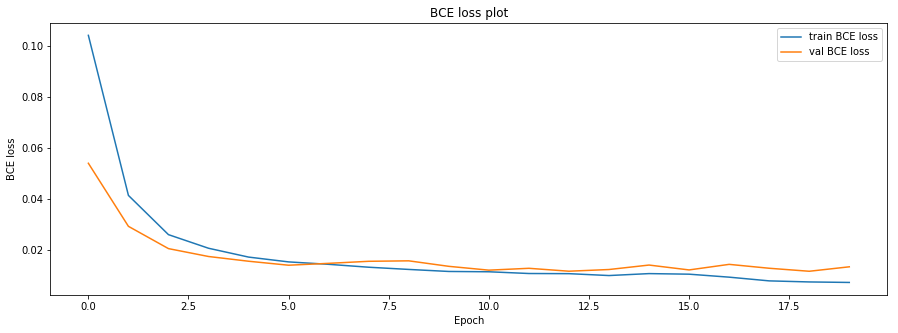

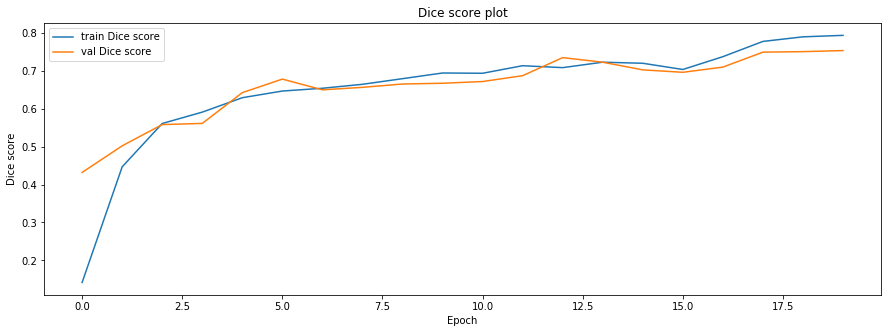

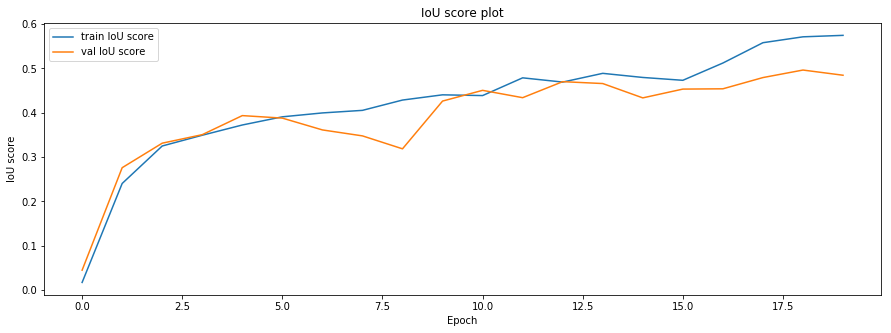

In [12]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

## Test prediction and submission

This training and validation takes about ~400 minutes which exceeds Kaggle's GPU usage limit of 60 minutes, we won't be able to submit the `submission.csv` file generated from this kernel. So, for test prediction and submission I've written a separate [UNet inference kernel](https://www.kaggle.com/rishabhiitbhu/unet-pytorch-inference-kernel), make sure you add the `model.pth` file generated from this kernel as dataset to test inference kernel.

I've used resnet-18 architecture in this kernel. It scores ~0.89 on LB. Try to play around with other architectures of `segmenation_models.pytorch` and see what works best for you, let me know in the comments :) and do upvote if you liked this kernel, I need some medals too. 😬

## Refrences:

Few kernels from which I've borrowed some cod[](http://)e:

* https://www.kaggle.com/amanooo/defect-detection-starter-u-net
* https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda

A big thank you to all those who share their code on Kaggle, I'm nobody without you guys. I've learnt a lot from fellow kagglers, special shout-out to [@Abhishek](https://www.kaggle.com/abhishek), [@Yury](https://www.kaggle.com/deyury), [@Heng](https://www.kaggle.com/hengck23), [@Ekhtiar](https://www.kaggle.com/ekhtiar), [@lafoss](https://www.kaggle.com/iafoss), [@Siddhartha](https://www.kaggle.com/meaninglesslives), [@xhulu](https://www.kaggle.com/xhlulu), and the list goes on..